# Analysis of results

In [1]:
# -- Libraries and defaults

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce

np.set_printoptions(precision=4, suppress=True)
pd.set_option("display.precision", 3)
pd.set_option("styler.format.precision", 3)

In [2]:
# -- Global configuration

DIR_EXPERIMENTS = "experiments/"
SAVE_FIG = False   # Save format is .pdf
DIR_SAVE = "figures/"
COLORS = plt.get_cmap("tab10")
COLOR_0, COLOR_1 = COLORS(0), COLORS(1)
FONT_SIZE_LATEX = 15  # Font size for saving figures

In [3]:
# -- Set matplotlib parameters

plt.rc('axes', prop_cycle=plt.cycler('color', COLORS.colors))

if SAVE_FIG:  # Mirror the style of a specific LaTeX document
    plt.rcParams.update(
        {
            "font.family": "serif",
            "font.size": FONT_SIZE_LATEX,
            "legend.fontsize": FONT_SIZE_LATEX,
            "axes.titlesize": FONT_SIZE_LATEX,
            "axes.labelsize": FONT_SIZE_LATEX,
            "xtick.labelsize": FONT_SIZE_LATEX,
            "ytick.labelsize": FONT_SIZE_LATEX,
            # "font.serif": [],
            "axes.linewidth": 0.75,
            "text.usetex": True,
            "pgf.rcfonts": False,
            "pgf.texsystem": "pdflatex",  # default is xetex
            "pgf.preamble": "\n".join(
                [
                    r"\renewcommand{\rmdefault}{ptm}",
                    r"\renewcommand{\sfdefault}{phv}",
                    r"\usepackage[T1]{fontenc}",
                    r"\usepackage[english]{babel}",
                    r"\usepackage{microtype}",
                    r"\makeatletter\g@addto@macro\bfseries{\boldmath}\makeatother",  # bold math
                ]
            ),
        }
    )
else:
    %matplotlib inline
    plt.rcParams['figure.dpi'] = 150

In [4]:
# -- Helper functions


def get_name_table(dataname):
    basename = os.path.basename(name)
    basename_split = basename.split("_")

    if "mixture" in dataname:
        model = "mixture"
    elif "gbm_" in dataname:
        model = "gbm"
    elif "gp_" in dataname:
        model = basename_split[5]
    else:
        model = basename_split[3]

    if "homoscedastic" in dataname:
        dataname_short = "Homoscedastic"
    elif "heteroscedastic" in dataname:
        dataname_short = "Heteroscedastic"
    elif "fractional" in dataname:
        dataname_short = "fBM"
    elif "brownian" in dataname:
        dataname_short = "BM"
    elif "exponential" in dataname:
        dataname_short = "Sq. exp"
    elif "ornstein_uhlenbeck" in dataname:
        dataname_short = "O-U"
    elif "gbm_rkhs" in dataname:
        dataname_short = "GBM + RKHS"
    elif "gbm_l2" in dataname:
        dataname_short = "GBM + $L^2$"
    else:
        dataname_short = model.capitalize()

    return dataname_short


def get_name_graph(dataname):
    basename = os.path.basename(dataname)
    basename_split = basename.split("_")

    if "mixture" in dataname:
        model = "mixture"
    elif "gbm_" in dataname:
        model = "gbm"
    elif "gp_" in dataname:
        model = basename_split[5]
    else:
        model = basename_split[3]

    real_data = False
    if "homoscedastic" in dataname:
        dataname_short = "Homoscedastic"
    elif "heteroscedastic" in dataname:
        dataname_short = "Heteroscedastic"
    elif "fractional" in dataname:
        dataname_short = "Fractional Brownian"
    elif "brownian" in dataname:
        dataname_short = "Standard Brownian"
    elif "exponential" in dataname:
        dataname_short = "Gaussian"
    elif "ornstein_uhlenbeck" in dataname:
        dataname_short = "Ornstein-Uhlenbeck"
    elif "gbm_rkhs" in dataname:
        dataname_short = "GBM + RKHS"
    elif "gbm_l2" in dataname:
        dataname_short = "GBM + $L^2$"
    else:
        dataname_short = model.capitalize()
        real_data = True

    if "smoothing" in basename:
        dataname_short += " - smooth"
    if "p_free" in basename:
        dataname_short += " (p free)"

    return dataname_short, real_data


def separate_df(df, key):
    df_bayesian = df[~df["Estimator"].str.contains("\+")]
    df_bayesian = df_bayesian.sort_values(key)
    df_var_sel = df[df["Estimator"].str.contains("\+")]
    df_var_sel = df_var_sel.sort_values(key)

    return df_bayesian, df_var_sel


def get_size_latex(width, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    [https://jwalton.info/Embed-Publication-Matplotlib-Latex/]

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == "thesis":
        width_pt = 426.79135
    elif width == "beamer":
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**0.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

## Dependence on parameters

In [21]:
# -- Configuration

DIR = DIR_EXPERIMENTS + "mixture_dependence_acc_p.csv"
X_LABEL_DEPENDENCE = "p"

In [22]:
# -- Read data

df = pd.read_csv(DIR)
df_bayesian, df_var_sel = separate_df(df, X_LABEL_DEPENDENCE)

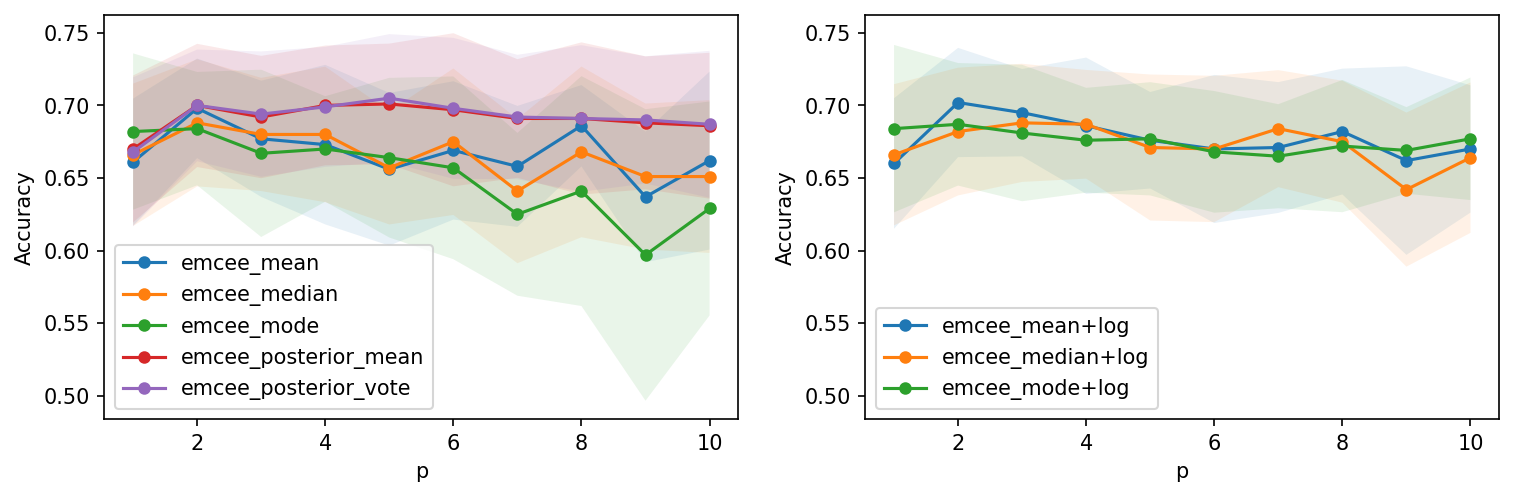

In [23]:
# -- Plot data

SCORE = "Acc" if any("Acc" in string for string in df.columns) else "RMSE"
SCORE_STR = "Accuracy" if SCORE == "Acc" else SCORE
FIGSIZE = (14, 5) if SAVE_FIG else (12, 3.5)

fig, ax = plt.subplots(1, 2, figsize=FIGSIZE, sharey=True)
for i, df in enumerate([df_bayesian, df_var_sel]):
    ax[i].set_xlabel(X_LABEL_DEPENDENCE)
    ax[i].set_ylabel(f"{SCORE_STR}")
    for key, grp in df.groupby(["Estimator"]):
        x, y = grp[X_LABEL_DEPENDENCE], grp[f"Mean {SCORE}"]
        yerror = grp[f"SD {SCORE}"]
        ax[i].plot(x, y, label=key[0], marker=".", markersize=10)
        ax[i].fill_between(x, y - yerror, y + yerror, alpha=0.1)

legend_fontsize = FONT_SIZE_LATEX - 1 if SAVE_FIG else None
ax[0].legend(fontsize=legend_fontsize)
ax[1].legend(loc='lower left', fontsize=legend_fontsize)
ax[1].tick_params(labelleft=True)

if SAVE_FIG:
    plt.savefig(
        DIR_SAVE + os.path.basename(DIR).split(".")[0] + ".pdf", bbox_inches="tight"
    )

## CV results

In [8]:
# -- Configuration

KIND = "linear"  # 'linear' or 'logistic'
METHOD = "emcee"
SMOOTHING = False
P_FREE = False
DIR = DIR_EXPERIMENTS + "out/"
SCORE_REG = "RMSE"  # 'RMSE' or 'rRMSE'

KIND_STR = "reg" if KIND == "linear" else "clf"
SCORE_STR = SCORE_REG if KIND == "linear" else "Acc"
SCORE_STR_FULL = SCORE_REG if KIND == "linear" else "Accuracy"

### Data gathering

In [9]:
# -- Data reading functions


def get_filenames(*dirs, extension="csv"):
    rkhs = []
    l2 = []
    non_gp = []
    real = []

    dirs_lst = [d for d in dirs if d is not None]

    for dirname in dirs_lst:
        for file in os.listdir(dirname):
            filename = file.split(".")[0]
            ext = file.split(".")[1]

            if SMOOTHING and "smoothing" not in filename:
                continue
            if not SMOOTHING and "smoothing" in filename:
                continue

            if P_FREE and "p_free" not in filename:
                continue
            if not P_FREE and "p_free" in filename:
                continue

            if METHOD in filename and KIND_STR in filename and ext == extension:
                if KIND == "linear" and "gbm" in filename:
                    non_gp += [dirname + filename]
                elif KIND == "logistic" and "mixture" in filename:
                    non_gp += [dirname + filename]
                elif "rkhs" in filename:
                    rkhs += [dirname + filename]
                elif "l2" in filename:
                    l2 += [dirname + filename]
                else:
                    real += [dirname + filename]

    # Sort
    for dataset in [rkhs, l2, non_gp, real]:
        dataset.sort(key=lambda x: x.split("/")[-1])

    return rkhs, l2, non_gp, real

In [10]:
# -- Data reading

rkhs, l2, non_gp, real = get_filenames(DIR)

### Score tables

In [11]:
# -- Table configuration

PRINT_LATEX = False  # whether to print tables in Latex format
dataname = "non_gp"  # 'rkhs', 'l2', 'non_gp' or 'real'

In [12]:
# -- Create tables

dfs_bayesian = []
dfs_var_sel = []

if dataname == "rkhs":
    data_all = rkhs
elif dataname == "l2":
    data_all = l2
elif dataname == "non_gp":
    data_all = non_gp
else:
    data_all = real

for name in data_all:
    kernel = get_name_table(name)
    df = pd.read_csv(name + ".csv")
    score_lst = [f"Mean {SCORE_STR}", f"SD {SCORE_STR}"]

    # Convert float to strings
    df[score_lst] = df[score_lst].map(lambda x: "{:.3f}".format(x))

    # Join Mean and SD
    df[kernel] = df[score_lst[0]] + " (" + df[score_lst[1]] + ")"
    df = df[["Estimator", kernel]]

    df_bayesian, df_var_sel = separate_df(df, "Estimator")
    dfs_bayesian.append(df_bayesian)
    dfs_var_sel.append(df_var_sel)

In [13]:
# -- Show tables

print(
    "--> "
    + KIND.capitalize()
    + " "
    + METHOD
    + " "
    + dataname.upper()
    + (" (smooth)" if SMOOTHING else "")
    + " <--\n"
)

for dfs in [dfs_bayesian, dfs_var_sel]:
    df_merge = reduce(lambda df1, df2: df1.merge(df2, on="Estimator", how="inner"), dfs)
    if PRINT_LATEX:
        print(df_merge.to_latex(index=False))
    else:
        display(df_merge)

--> Linear emcee NON_GP <--



,Estimator,GBM + $L^2$,GBM + RKHS
0,apls,0.716 (0.034),1.456 (0.170)
1,emcee_mean,0.948 (0.354),1.278 (0.622)
2,emcee_median,0.737 (0.036),0.747 (0.031)
3,emcee_mode,0.786 (0.106),0.928 (0.275)
4,emcee_posterior_mean,0.763 (0.083),0.786 (0.084)
5,flin,0.726 (0.033),2.427 (0.352)
6,fpls1,0.731 (0.040),2.336 (0.365)
7,lasso,0.726 (0.042),0.759 (0.073)
8,pls1,0.710 (0.029),1.309 (0.122)
9,ridge,0.721 (0.035),1.175 (0.205)


,Estimator,GBM + $L^2$,GBM + RKHS
0,emcee_mean+ridge,0.725 (0.040),1.432 (1.059)
1,emcee_median+ridge,0.738 (0.033),0.780 (0.093)
2,emcee_mode+ridge,0.733 (0.040),0.760 (0.073)
3,fpca+ridge,0.716 (0.036),1.873 (0.302)
4,manual+ridge,0.724 (0.046),2.253 (0.226)
5,pca+ridge,0.719 (0.036),1.879 (0.304)
6,pls+ridge,0.713 (0.030),1.299 (0.125)
7,rmh+ridge,0.805 (0.051),1.640 (0.189)


### Score graphs

In [14]:
# -- Plotting functions


def plot_df(df, ax=None, legend=False, limit=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.margins(x=0.05)

    estimator = df["Estimator"].to_numpy(dtype=str)

    # Quick fix for name
    for i, name in enumerate(estimator):
        if "logistic" in name:
            estimator[i] = estimator[i].replace("+logistic", "+log")

    score = df["Mean " + SCORE_STR].to_numpy()
    sd = df["SD " + SCORE_STR].to_numpy()
    ours_idx = []

    # Outliers
    if KIND == "linear":
        if limit is None:
            q3, q1 = np.percentile(score + sd, [75, 25])
            limit = q3 + 1.5 * (q3 - q1)  # IQR

        outliers_idx = np.where(score > limit)[0]
        outliers = estimator[outliers_idx]
        symbol = ">"
    else:
        if limit is None:
            q3, q1 = np.percentile(score - sd, [75, 25])
            limit = q1 - 1.5 * (q3 - q1)  # IQR
        outliers_idx = np.where(score < limit)[0]
        outliers = estimator[outliers_idx]
        symbol = "<"

    # Plot our models
    all_outliers_ours = True
    for idx, idx_where in enumerate(np.char.find(estimator, METHOD)):
        if idx_where < 0:
            continue
        ours_idx.append(idx)

        if estimator[idx] in outliers:
            handles_ours_outliers = ax.plot(
                limit, estimator[idx], symbol, color=COLOR_1, label="Our methods"
            )
        else:
            all_outliers_ours = False
            handles_ours = ax.errorbar(
                score[idx],
                estimator[idx],
                xerr=sd[idx],
                color= COLOR_1,
                ecolor=COLOR_1,
                lw=1,
                fmt="o",
                markersize=5,
                label="Our methods",
            )

    estimator_rest = np.delete(estimator, ours_idx)
    score_rest = np.delete(score, ours_idx)
    sd_rest = np.delete(sd, ours_idx)

    # Plot comparison models
    all_outliers_rest = True
    for e, s, sdd in zip(estimator_rest, score_rest, sd_rest):
        if e in outliers:
            handles_rest_outliers = ax.plot(
                limit, e, symbol, color=COLOR_0, label="Reference methods"
            )
        else:
            all_outliers_rest = False
            handles_rest = ax.errorbar(
                s,
                e,
                xerr=sdd,
                color=COLOR_0,
                ecolor=COLOR_0,
                lw=1,
                fmt="o",
                markersize=5,
                label="Reference methods",
            )

    if all_outliers_ours:
        handles_ours = handles_ours_outliers
    if all_outliers_rest:
        handles_rest = handles_rest_outliers

    handles = [handles_ours, handles_rest]

    score_rest_no_outliers = np.delete(score, np.concatenate((outliers_idx, ours_idx)))
    if len(score_rest_no_outliers) > 0:
        handles_mean = ax.axvline(
            x=score_rest_no_outliers.mean(),
            color=COLOR_0,
            ls="--",
            lw=1.3,
            label="Mean of reference methods",
        )
        handles += [handles_mean]

    if legend:
        ax.legend(handles=handles, bbox_to_anchor=(1, 1))

    return handles


def plot_data_all(
    data,
    data_type_name,
    limit=None,
    legend=True,
    save=False,
    figsize=[None, None],
    bbox_legend=[None, None],
):
    n_data = len(data)
    if limit is None:
        limit = [(None, None)] * n_data

    if figsize[0] is None:
        figsize[0] = 2.5 * n_data
    if figsize[1] is None:
        figsize[1] = 7
    if bbox_legend[0] is None:
        if n_data == 2:
            bbox_legend[0] = 1.15
        elif n_data == 3:
            bbox_legend[0] = 1.80
        elif n_data == 4:
            bbox_legend[0] = 2.45
        else:
            bbox_legend[0] = 1.0
    if bbox_legend[1] is None:
        bbox_legend[1] = -0.5

    fig = plt.figure(figsize=figsize)
    subfigs = fig.subfigures(nrows=1, ncols=n_data)
    if n_data == 1:
        subfigs = [subfigs]

    for j, (dataname, l) in enumerate(zip(data, limit)):
        df = pd.read_csv(dataname + ".csv")
        dataname_short, real_data = get_name_graph(dataname)

        # Get different strategies and order by score
        df_bayesian, df_var_sel = separate_df(df, "Estimator")

        ##
        # PLOT
        ##

        subfig = subfigs[j]
        subfig.suptitle(dataname_short, fontweight="semibold", y=0.96)
        ax1, ax2 = subfig.subplots(nrows=2, ncols=1, sharex=True)

        if j != 0 and j != n_data - 1:
            ax1.set_yticks([])
            ax2.set_yticks([])
        if j != 0 and j == n_data - 1:
            ax1.yaxis.tick_right()
            ax2.yaxis.tick_right()

        kind_title = "Regression" if KIND == "linear" else "Classification"
        ax1.set_title(f"{kind_title} methods")
        ax2.set_title("Two-stage methods")
        ax1.set_xlabel(SCORE_STR_FULL)
        ax2.set_xlabel(SCORE_STR_FULL)
        ax1.tick_params(labelbottom=True)
        ax1.xaxis.set_major_locator(plt.MaxNLocator(4))
        ax1.xaxis.set_major_formatter(plt.FormatStrFormatter("%0.2f"))

        _ = plot_df(df_bayesian, ax1, legend=False, limit=l[0])
        handles = plot_df(df_var_sel, ax2, limit=l[1])

        if legend and j == 0:
            ax2.legend(
                loc="lower center",
                handles=handles,
                ncol=3,
                fancybox=True,
                shadow=True,
                bbox_to_anchor=bbox_legend,
            )

        subfig.subplots_adjust(hspace=0.4)

    if save:
        filename_save = (
            ("reg_" if KIND == "linear" else "clf_")
            + METHOD
            + "_"
            + data_type_name
            + ("_p_free" if "p_free" in dataname else "")
            + ("_smooth" if "smoothing" in dataname else "")
            + ".pdf"
        )
        plt.savefig(DIR_SAVE + filename_save, bbox_inches="tight", backend="pgf")

In [15]:
# -- Plot configuration

dataname = "real"
LIMIT_EXPERIMENTS = True  # whether to use pre-defined limits for the plots
bbox_legend = [None, None]
height = 7

In [16]:
# -- Data limits for plotting

if LIMIT_EXPERIMENTS:
    if KIND == "linear":
        if dataname == "rkhs":
            limit = [(None, None), (None, None), (None, None), (1, None)] 
        elif dataname == "l2":
            limit = [(None, None), (None, None), (None, 0.90), (0.95, None)]
        elif dataname == "non_gp":
            limit = [(None, 0.9), (None, None)]  
        else:  # real
            limit = [(None, None), (None, None), (8, 8)]  
    else:  # logistic
        if dataname == "rkhs":
            limit = [(None, None), (None, None), (None, None), (0.6, None)] 
        elif dataname == "l2":
            limit = [(0.4, None), (None, None), (None, None), (None, None)]
        elif dataname == "non_gp":
            limit = [(None, None), (None, None)]  
        else:  # real
            limit = [(None, None), (None, None), (None, None)]  
else:  # custom limits
    limit = [(None, None), (None, None), (None, None), (None, None)]  

--> Linear emcee REAL <--


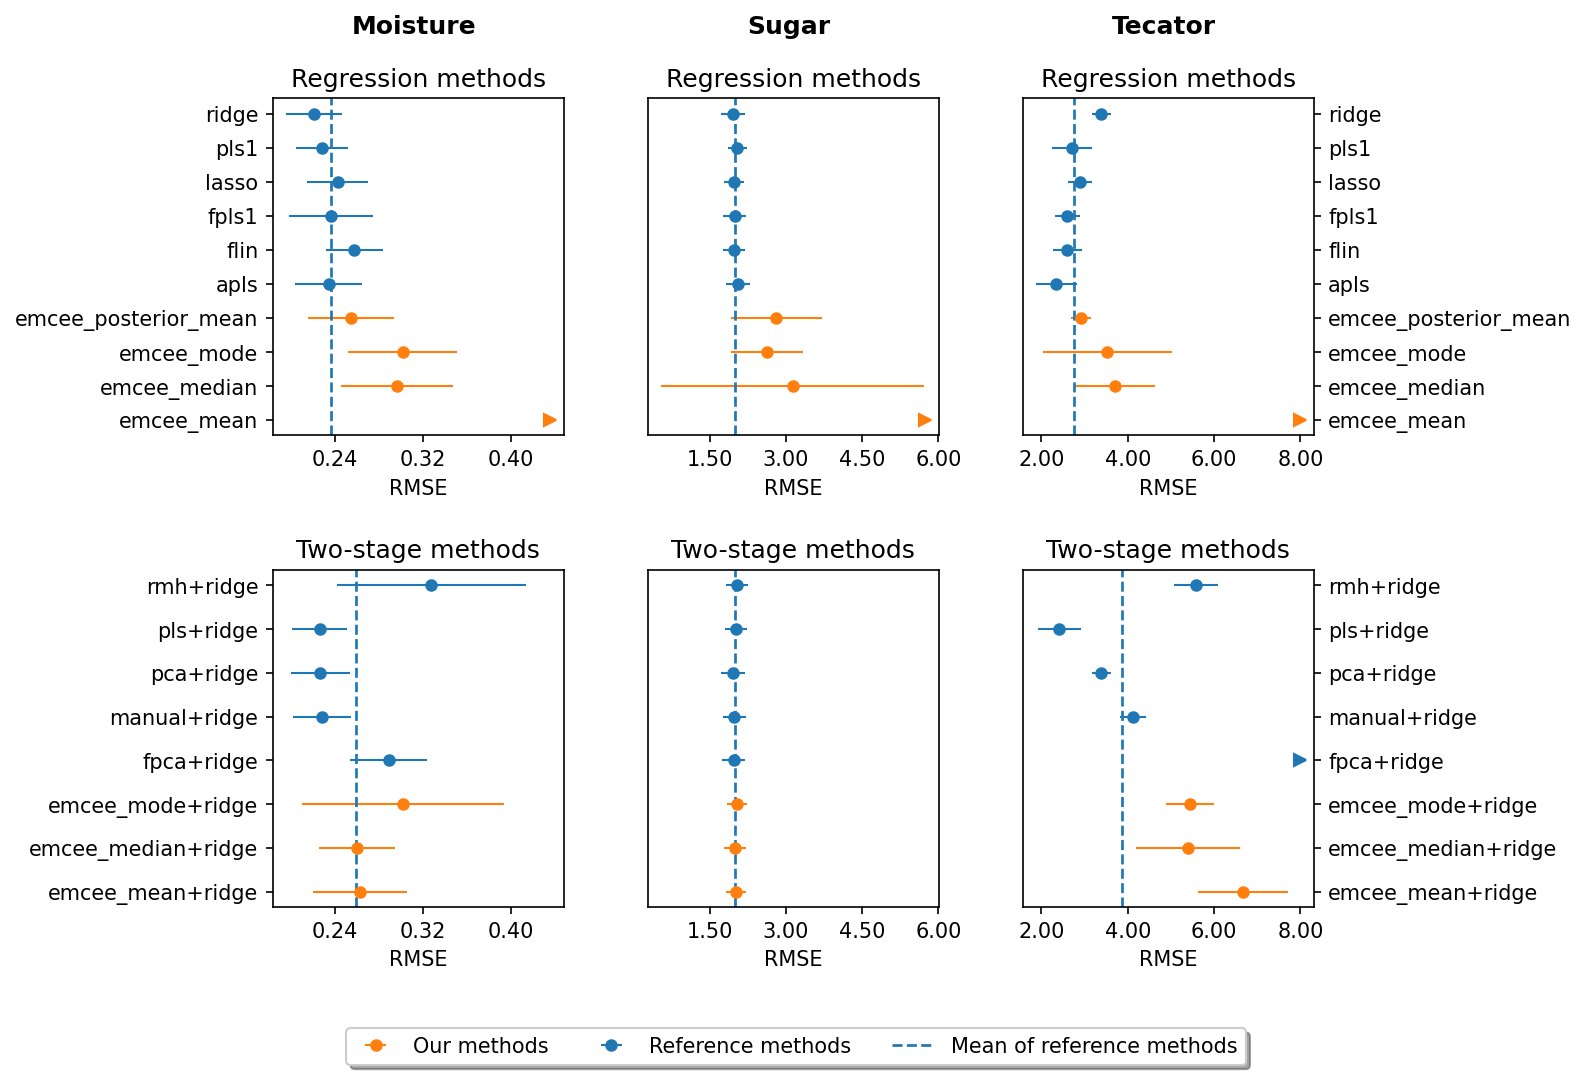

In [17]:
# -- Plot score graphs

if dataname == "rkhs":
    data_all = rkhs
elif dataname == "l2":
    data_all = l2
elif dataname == "non_gp":
    data_all = non_gp
else:
    data_all = real

print(
    "--> "
    + KIND.capitalize()
    + " "
    + METHOD
    + " "
    + dataname.upper()
    + (" (smooth)" if SMOOTHING else "")
    + " <--"
)

plot_data_all(
    data_all,
    dataname,
    limit=limit,
    legend=True,
    figsize=[None, height],  # Default width is 2.5*n_data
    bbox_legend=bbox_legend,
    save=SAVE_FIG,
)

### CV data

In [18]:
rkhs, l2, non_gp, real = get_filenames(DIR, extension="npz")

In [19]:
# Example
arr = np.load(rkhs[0] + ".npz", allow_pickle=True)
print("Keys:")
for a in arr.keys():
    print(a)

Keys:
score_ref_all
score_bayesian_all
score_var_sel_all


In [20]:
# Each row is a different repetition, inside the arrays are # n_splits x params_shape
# e.g. for 5 folds, p in [2, 3] and eta in [0.01, 0.1], shape is (5, 2, 2).
arr["score_bayesian_all"]

# There are also the parameter vectors (eta, p) and, in the case of INCLUDE_P,
# the effective n_components used in each case.

array([{'posterior_mean': array([[[-1.5637, -1.5622, -1.5345, -1.5332, -1.5424, -1.5591, -1.568 ],
               [-0.9037, -0.8906, -0.949 , -0.9048, -0.9691, -0.973 , -1.0017],
               [-0.9748, -0.8933, -0.9275, -0.9099, -1.1402, -0.9146, -0.9999],
               [-0.8166, -0.8325, -0.8831, -0.8409, -0.9409, -0.9592, -0.9863],
               [-0.9043, -0.7942, -0.813 , -0.7869, -0.7466, -0.7408, -1.3404],
               [-0.8402, -0.8304, -0.8485, -0.8852, -0.8143, -0.8307, -0.8565],
               [-0.8652, -0.7999, -0.7931, -0.8361, -0.7889, -0.7911, -0.8142],
               [-0.8839, -0.8214, -0.8821, -0.9112, -0.8739, -0.8424, -0.8654],
               [-1.118 , -0.8693, -0.834 , -0.8325, -0.8146, -0.8415, -1.497 ],
               [-0.9441, -0.8679, -0.8102, -0.805 , -0.8263, -0.807 , -0.9726]],

              [[-1.6068, -1.6044, -1.619 , -1.6175, -1.6266, -1.611 , -1.6155],
               [-1.0408, -0.9877, -1.0512, -0.9893, -1.1387, -1.3514, -1.3532],
               [-0.